<a href="https://colab.research.google.com/github/magalaReuben/practicaldeepreinforcementlearning/blob/main/Lecture3/DeepQLearningPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install swig
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 34.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376210 sha256=825a037b1b365d454fe055482bffefef75033466ec9aa8421fa5c68085d71547
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [3]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random


In [4]:
env = gym.make('LunarLander-v2')

print("observation_space", *env.observation_space.shape)
print("action_space", env.action_space.n)

observation_space 8
action_space 4


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import numpy as np

MEM_SIZE = 10000
BATCH_SIZE = 64

class ReplayMemory:
    def __init__(self):
        self.mem_count = 0

        self.states = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=bool)

    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE

        self.states[mem_index]  = state
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_
        self.dones[mem_index] =  1 - done

        self.mem_count += 1

    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)

        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

In [7]:
LEARNING_RATE = 0.0001

class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = env.action_space.n

        self.layer1 = nn.Linear(*self.input_shape, 1024)
        self.layer2 = nn.Linear(1024, 1024)
        self.layer3 = nn.Linear(1024, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.SmoothL1Loss()
        self.to(device)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)

        return x

In [12]:
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.0005

gamma = 0.95

class DqnAgent:
    def __init__(self):
        self.memory = ReplayMemory()
        self.exploration_rate = max_epsilon
        self.network = DQN()

    def choose_action(self, state):
        random_num = random.uniform(0, 1)
        if random_num > self.exploration_rate:
            state = torch.tensor(state).float().detach().to(device).unsqueeze(0)
            q_values = self.network(state)
            return torch.argmax(q_values).item()
        else:
            return env.action_space.sample()

    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return

        states, actions, rewards, next_states, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.bool).to(device)
        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)

        q_values = self.network(states)
        next_q_values = self.network(next_states)

        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0]

        q_target = rewards + gamma * predicted_value_of_future * dones

        loss = self.network.loss(q_target, predicted_value_of_now)
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= decay_rate
        self.exploration_rate = max(min_epsilon, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate

Episode 1 Average Reward -62.43871321903015 Best Reward 0 Last Reward -62.43871321903015 Epsilon 0.05
Episode 2 Average Reward -387.11584910432 Best Reward 0 Last Reward -711.7929849896099 Epsilon 0.05
Episode 3 Average Reward -549.2345577246391 Best Reward 0 Last Reward -873.4719749652774 Epsilon 0.05
Episode 4 Average Reward -529.8628096911699 Best Reward 0 Last Reward -471.7475655907626 Epsilon 0.05
Episode 5 Average Reward -549.2569557324287 Best Reward 0 Last Reward -626.8335398974637 Epsilon 0.05
Episode 6 Average Reward -561.3522742876054 Best Reward 0 Last Reward -621.828867063489 Epsilon 0.05
Episode 7 Average Reward -526.7020924289901 Best Reward 0 Last Reward -318.8010012772983 Epsilon 0.05
Episode 8 Average Reward -501.46595648250855 Best Reward 0 Last Reward -324.81300485713746 Epsilon 0.05
Episode 9 Average Reward -511.3160600659221 Best Reward 0 Last Reward -590.1168887332302 Epsilon 0.05
Episode 10 Average Reward -525.0227586586855 Best Reward 0 Last Reward -648.3830459

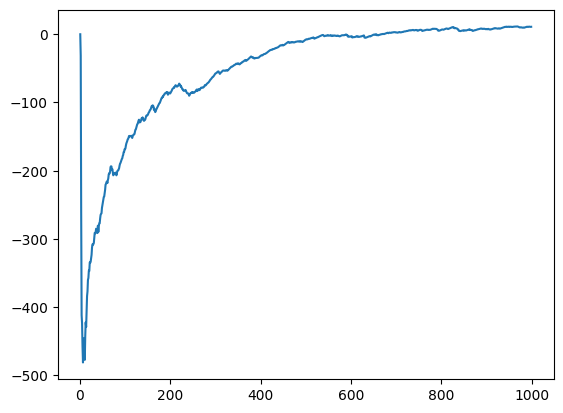

In [13]:
EPISODES = 100000
best_reward = float('-inf')
average_reward = 0
episode_number = []
average_reward_number = []
observation_space = env.observation_space.shape[0]

agent = DqnAgent()

for i in range(1, EPISODES):
    state = env.reset()[0]
    state = np.reshape(state, [1, observation_space])
    score = 0

    while True:
        #env.render()
        action = agent.choose_action(state)
        state_, reward, terminated, truncated, info = env.step(action)
        state_ = np.reshape(state_, [1, observation_space])
        agent.memory.add(state, action, reward, state_, terminated)
        agent.learn()
        state = state_
        score += reward

        if terminated:
            if score > best_reward:
                torch.save(agent.network.state_dict(), 'best_model_weights.pth')
                best_reward = score
            average_reward += score
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break

        episode_number.append(i)
        average_reward_number.append(average_reward/i)

plt.plot(episode_number, average_reward_number)
plt.show()